### 12개월 데이터로 예측해보기

In [5]:
# 모델 불러오기
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        # input size = 12
        self.rnn = nn.RNN(input_size=12, hidden_size=30, num_layers=2, batch_first=True)
        self.fc = nn.Linear(30, 1)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

In [6]:
# Load model
model = RNN()
model.load_state_dict(torch.load('noo_model_12m.pth'))

<All keys matched successfully>

In [3]:
# 모델 사용하기
# 1. 데이터 로드
import pandas as pd
import numpy as np

data = pd.read_csv('../../DATA/SMP_201004_202403_norm.csv')
data.head()
# norm -> value column
data['value'] = data['norm']
data.drop(['날짜', '통합'], axis=1, inplace=True)
data.head()

,norm,denorm,date,value
0,-1.165759,50.705398,2001-04-30,-1.165759
1,-1.123687,52.552364,2001-05-31,-1.123687
2,-1.153413,51.247385,2001-06-30,-1.153413
3,-1.240408,47.428339,2001-07-31,-1.240408
4,-1.357382,42.293200,2001-08-31,-1.357382


In [4]:
def denorms(x):
    return x * 43.89968 + 101.88185

In [13]:
pred_total = data['norm'][:12]
pred_length = 12
for i in range(pred_length):
    values = torch.tensor(pred_total[-12:]).unsqueeze(0).float()
    pred = model(values.unsqueeze(0))
    pred_total = np.append(pred_total, pred.item())

print(pred_total)
pred_total_denorm = denorms(pred_total).tolist()
print(pred_total_denorm)

[-1.16575911 -1.12368669 -1.15341308 -1.24040792 -1.35738233 -1.30618676
 -1.25172998 -1.24699768 -1.03867404 -0.99693181 -1.13335897 -1.17043724
 -1.25229549 -1.34508502 -1.51492107 -1.5170306  -1.46386838 -1.39418864
 -1.31043863 -1.16416252 -1.06989813 -1.09293997 -1.12794149 -1.17023766]
[50.705398147716146, 52.55236408564794, 51.24738468682304, 47.42833920547231, 42.29319991025461, 44.540669304692265, 46.93130439988236, 47.13905095236847, 56.28439188515072, 58.116862619177226, 52.12775400583361, 50.500029836543625, 46.906478544464115, 42.83304783700943, 35.377299839267735, 35.28469225320816, 37.61849657375336, 40.67741473453522, 44.35401335319519, 50.77548805353165, 54.913664525833134, 53.902134931468964, 52.365579564533235, 50.508791184139255]


In [ ]:
# start_date 기준 data['norm'] 의 12개월
start_date = '2023-04-01'


In [19]:
# 함수 만들기
# - 시작일, 예측기간을 넣어 pred_df 만들기
def predict_df(start_date, pred_length):
    pred_total = data['norm'][:12]
    for i in range(pred_length):
        values = torch.tensor(pred_total[-12:]).unsqueeze(0).float()
        pred = model(values.unsqueeze(0))
        pred_total = np.append(pred_total, pred.item())
    pred_total_denorm = denorms(pred_total).tolist()
    pred_df = pd.DataFrame({'date': pd.date_range(start_date, periods=pred_length, freq='M'), 'value': pred_total_denorm[-pred_length:]})
    return pred_df

pred_df_0110_0210 = predict_df('2001-10-01', 12)
pred_df_0110_0210

,date,value
0,2001-10-31,46.906479
1,2001-11-30,42.833048
2,2001-12-31,35.377300
3,2002-01-31,35.284692
4,2002-02-28,37.618497
5,2002-03-31,40.677415
6,2002-04-30,44.354013
7,2002-05-31,50.775488
8,2002-06-30,54.913665
9,2002-07-31,53.902135


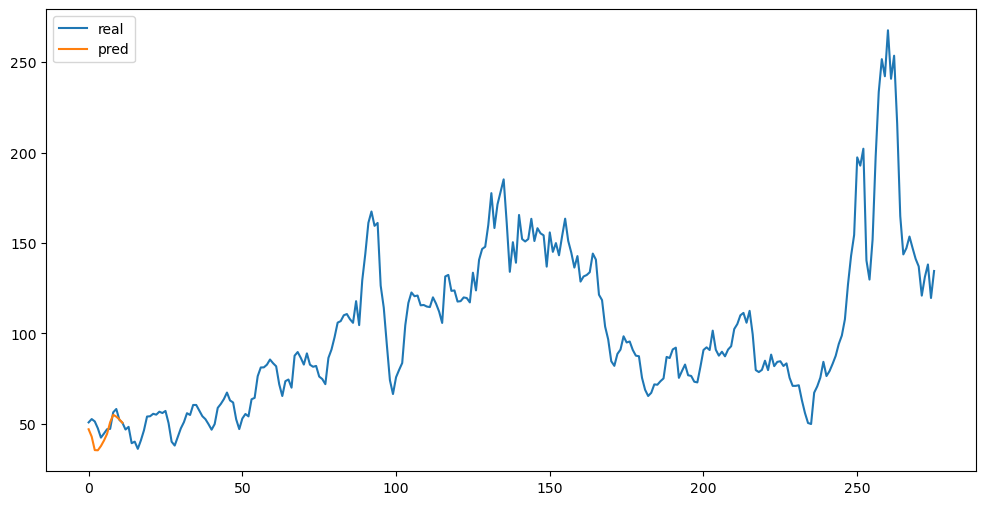

In [20]:
# 예측 데이터 생성
pred_df = predict_df('2023-04-30', 12)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['denorm'], label='real')
plt.plot(pred_df['value'], label='pred')
plt.legend()
plt.show()

### 이대로 시각화까지 한 함수로!

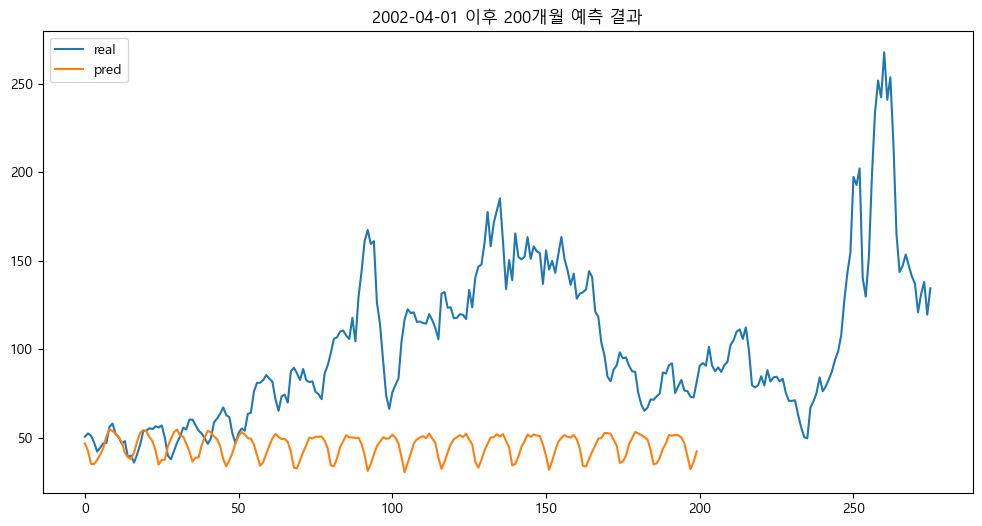

,date,value
0,2002-04-30,46.906479
1,2002-05-31,42.833048
2,2002-06-30,35.377300
3,2002-07-31,35.284692
4,2002-08-31,37.618497
...,...,...
195,2018-07-31,46.942729
196,2018-08-31,39.639007
197,2018-09-30,32.338896
198,2018-10-31,36.579032


In [27]:
# 시각화를 포함한 함수
def predict_plt(start_date, pred_length, PLOT=True):
    # date가 '2002-04-01' 이전이면 에러 출력
    if start_date < '2002-04-01':
        print('date error: 2002-04-01 이후로만 입력해주세요')
        return
    else:
        pred_total = data['norm'][:12]
        for i in range(pred_length):
            values = torch.tensor(pred_total[-12:]).unsqueeze(0).float()
            pred = model(values.unsqueeze(0))
            pred_total = np.append(pred_total, pred.item())
        pred_total_denorm = denorms(pred_total).tolist()
        pred_df = pd.DataFrame({'date': pd.date_range(start_date, periods=pred_length, freq='M'), 'value': pred_total_denorm[-pred_length:]})
        if PLOT:
            # 한글 인코딩
            plt.rc('font', family='Malgun Gothic')
            plt.figure(figsize=(12, 6))
            plt.plot(data['denorm'], label='real')
            plt.plot(pred_df['value'], label='pred')
            plt.title(f'{start_date} 이후 {pred_length}개월 예측 결과')
            plt.legend()
            plt.show()
    return pred_df

predict_plt('2002-04-01', 200)

# 어... 이건 좀 문제 있다

### 함수 잘못 짰다 주피터는 왜 또 버벅거려

In [43]:
# 구성 다시 짜기
# 1. 데이터 로드 : data
# 2. 모델 불러오기 : model
# 3. 예측 df 만들기
# - 시작일 입력
# - 예측기간 입력
# - 시작일은 2002-04-01 이후, 2023-04-30 이전
# - 학습은 전체 데이터를 기준으로 학습

# initial data 잡는 게 문제
# - 시작일을 기준으로 12개월 전 데이터가 pred_total
# - 그냥 학습 시작일이라 하면 되잔나??

start_idx = data[data['date'] == '2023-04-30'].index.item()
print(start_idx)
pred_length = 12
pred_total = data['norm'][start_idx: start_idx+12].tolist()
pred_total, len(pred_total) # Good!

264


([1.4345923260454374,
  0.951217528530144,
  1.0307169650677677,
  1.176276105318603,
  1.032767093803695,
  0.8954084684965689,
  0.8001913783168362,
  0.4320793741770091,
  0.6660218421544861,
  0.8241095469026545,
  0.4020108193834095,
  0.7423321895473338],
 12)

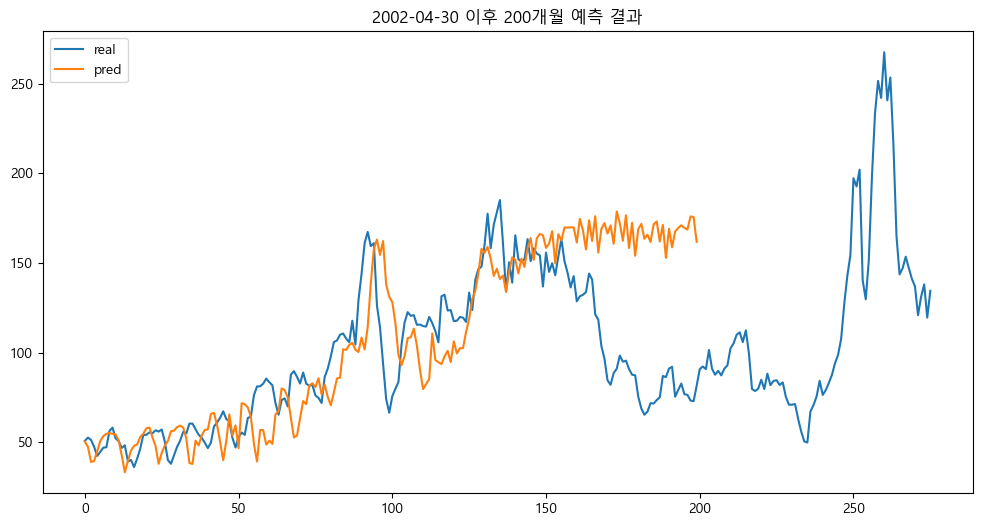

,date,value
0,2002-04-30,50.265576
1,2002-05-31,47.358961
2,2002-06-30,38.963866
3,2002-07-31,39.400554
4,2002-08-31,44.873890
...,...,...
195,2018-07-31,169.639821
196,2018-08-31,168.664882
197,2018-09-30,175.989909
198,2018-10-31,175.675762


In [7]:
# 시각화를 포함한 함수
def predict_plt(start_date, pred_length, PLOT=True):
    # date가 '2023-04-30' 이후이면 에러 출력
    if start_date > '2023-04-30':
        print('date error: 2023-04-30 이전으로만 입력해주세요')
        return
    else:
        start_idx = data[data['date'] == start_date].index.item()
        pred_total = data['norm'][start_idx: start_idx+12].tolist()
        for i in range(pred_length):
            values = torch.tensor(pred_total[-12:]).unsqueeze(0).float()
            pred = model(values.unsqueeze(0))
            pred_total = np.append(pred_total, pred.item())
        pred_total_denorm = denorms(pred_total).tolist()
        pred_df = pd.DataFrame({'date': pd.date_range(start_date, periods=pred_length, freq='M'), 'value': pred_total_denorm[-pred_length:]})
        if PLOT:
            # 한글 인코딩
            plt.rc('font', family='Malgun Gothic')
            plt.figure(figsize=(12, 6))
            plt.plot(data['denorm'], label='real')
            plt.plot(pred_df['value'], label='pred')
            plt.title(f'{start_date} 이후 {pred_length}개월 예측 결과')
            plt.legend()
            plt.show()
    return pred_df

predict_plt('2002-04-30', 200)

### 아 그래프 시작이 다르다

In [ ]:
pred_df = predict_plt('2023-04-30', 12)

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['denorm'], label='real')
plt.plot(pred_df['date'], pred_df['value'], label='pred')
plt.xticks(rotation=45)
plt.legend()
plt.show()


## 간단하게 가자 : 앞으로 몇 년 예측하고 싶은지만 나오게 하기